# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]

### Member 1: Aniket Mishra

### Member 2: Anindita Sarkar

### Member 3: It's A Me, Mario


In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub


# add additonal imports here
class FashionDataset(Dataset):
    def __init__(
        self, csv_file, img_dir, column_class="articleTypeId", transform=None
    ):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(
            self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg"
        )  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

## Importing more libraries cuz y not


In [2]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torch.nn as nn
from typing import Tuple, List, Dict, Optional, Type, Any
from torch import optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import time
from matplotlib import cm

import torch.multiprocessing

torch.multiprocessing.set_start_method("spawn", force=True)

from dataset import FashionDataset

Download data with kagglehub


In [3]:
# dataset_path = "/Users/aniket/TU_Eindhoven/2_Study/Q4_2AMM15_Deep_Learning/4_Code/2AMM15_Deep_Learning/Assighment_1/datasets/"

In [4]:
dataset_path = kagglehub.dataset_download(
    "paramaggarwal/fashion-product-images-small"
)
img_dir = os.path.join(dataset_path, "images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.


In [5]:
local_data_path = "/Users/aniket/TU_Eindhoven/2_Study/Q4_2AMM15_Deep_Learning/4_Code/2AMM15_Deep_Learning/Assighment_1/dataset"

In [6]:
dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
)

In [7]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


In [8]:
dataset.df

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0
...,...,...,...,...,...
35929,13398,Shirts,Topwear,1,0
35930,53734,Casual Shoes,Shoes,2,1
35931,11033,Tops,Topwear,6,0
35932,22334,Tshirts,Topwear,0,0


In [9]:
dataset.img_dir

'/Users/aniket/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images'

In [10]:
dataset.df["imageId"].min()

np.int64(1163)

In [11]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=60x80>, np.int64(15))

In [12]:
len(set(dataset.targets))

39

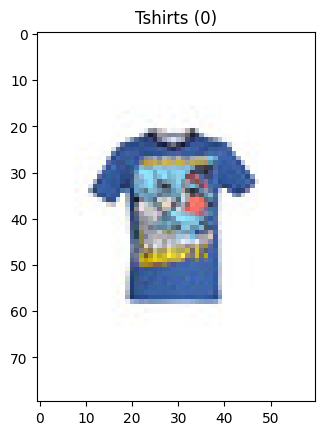

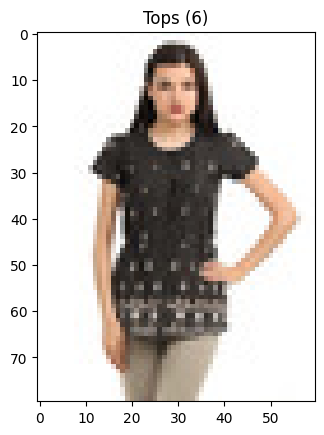

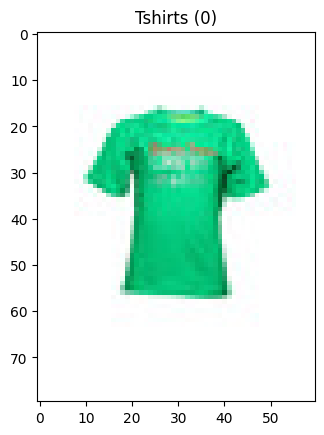

In [13]:
np.random.seed(42)
# np.random.seed(69)
random_indices = np.random.choice(len(dataset), 3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"] + f" ({label.item()})")
    plt.imshow(img)
    plt.show()

In [14]:
# Setting up default values, I forget to change them everywhere
batch_size = 512
learning_rate = 0.0001
all_birbs = sorted(list(set(dataset.targets)))
num_classes = len(set(dataset.targets))

resize_pixels_x = 128
resize_pixels_y = 128
crop_size = 128

In [15]:
transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.RandomResizedCrop(
            crop_size
        ),  # Crop yoinks stuff completely, gotta skip ig?
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(
            (-15, 15), interpolation=InterpolationMode.NEAREST
        ),  # Rotate +-15 degrees cuz not text, we can
        transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.2),
        # Data Augmentation - end
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

## Loading different datasets


In [16]:
# transform = transforms.Compose([...])  # your image transformations
train_dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
    transform=transform,
)
main_test_dataset = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    transform=test_transform,
)
new_test_dataset = FashionDataset(
    f"{local_data_path}/new_test.csv",
    img_dir,
    transform=test_transform,
)
main_support_dataset = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    transform=test_transform,
)
new_support_dataset = FashionDataset(
    f"{local_data_path}/new_support.csv",
    img_dir,
    transform=test_transform,
)
merged_test_dataset = FashionDataset(
    f"{local_data_path}/merged_test.csv",
    img_dir,
    transform=test_transform,
)  # merged corresponds to main+new
merged_support_dataset = FashionDataset(
    f"{local_data_path}/merged_support.csv",
    img_dir,
    transform=test_transform,
)

# datasets with categories
main_test_dataset_cat = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)
main_support_dataset_cat = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)


label_id_to_label_name = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i][
        "articleTypeName"
    ].iloc[0]
    for i in range(39)
}
label_id_to_label_name.update(
    {
        i: new_test_dataset.df[new_test_dataset.df["articleTypeId"] == i][
            "articleTypeName"
        ].iloc[0]
        for i in range(39, 39 + 30)
    }
)

## Task 1


In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()

        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetCNN2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNetCNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2)

        self.layer1 = ResidualBlock(16, 32, downsample=False)
        self.layer2 = ResidualBlock(32, 64, downsample=True)
        self.layer3 = ResidualBlock(64, 128, downsample=True)
        # self.layer4 = ResidualBlock(128, 128, downsample=True)
        self.layer4 = ResidualBlock(128, 256, downsample=True)

        self.dropout = nn.Dropout(0.1)

        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 128, 128)
            x = self.conv1(dummy_input)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_embeddings(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        return x


print("ResNet CNN2 defined")

ResNet CNN2 defined


In [18]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)
print(torch.version.xpu)

mps
None


In [20]:
model = ResNetCNN2(in_channels=3, num_classes=num_classes)
model = model.to(device)
model

ResNetCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): Ba

In [21]:
# Optional: Learning Rate Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Example: reduce LR every 7 epochs


In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score # 
import time # To time epochs
import matplotlib.pyplot as plt # For plotting loss and accuracy


In [23]:
num_epochs = 25
# batch_size is already defined in your provided code as 512
# learning_rate is already defined in your provided code as 0.0001
# num_classes is already defined based on your train_dataset (should be 39 for main classes)
# device is already defined

print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")


# 1. Define the Loss Function 
criterion = nn.CrossEntropyLoss()

# 2. Define the Optimizer
# You can experiment with other optimizers or parameters like weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Optional: Learning Rate Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Example: reduce LR every 7 epochs


Using device: mps
Number of classes: 39
Batch size: 512
Learning rate: 0.0001


In [24]:
import os
cpu_count = os.cpu_count()
cpu_count

12

Train loader: 71 batches, 35934 samples
Test loader: 4 batches, 1997 samples

Starting training...
Epoch [1/25], Step [17/71], Batch Loss: 2.8164
Epoch [1/25], Step [34/71], Batch Loss: 2.5286
Epoch [1/25], Step [51/71], Batch Loss: 2.4738
Epoch [1/25], Step [68/71], Batch Loss: 2.2619
Epoch [1/25] completed in 142.29s:
  Training Loss: 2.6393, Training Accuracy: 28.02%
  Test Loss: 1.8709, Test Accuracy: 45.62%, Test Balanced Accuracy: 27.05%
Epoch [2/25], Step [17/71], Batch Loss: 2.1545
Epoch [2/25], Step [34/71], Batch Loss: 1.9994
Epoch [2/25], Step [51/71], Batch Loss: 1.9179
Epoch [2/25], Step [68/71], Batch Loss: 1.8635
Epoch [2/25] completed in 139.47s:
  Training Loss: 2.0167, Training Accuracy: 41.76%
  Test Loss: 1.4376, Test Accuracy: 54.88%, Test Balanced Accuracy: 31.53%
Epoch [3/25], Step [17/71], Batch Loss: 1.7991
Epoch [3/25], Step [34/71], Batch Loss: 1.6782
Epoch [3/25], Step [51/71], Batch Loss: 1.7384
Epoch [3/25], Step [68/71], Batch Loss: 1.6422
Epoch [3/25] co

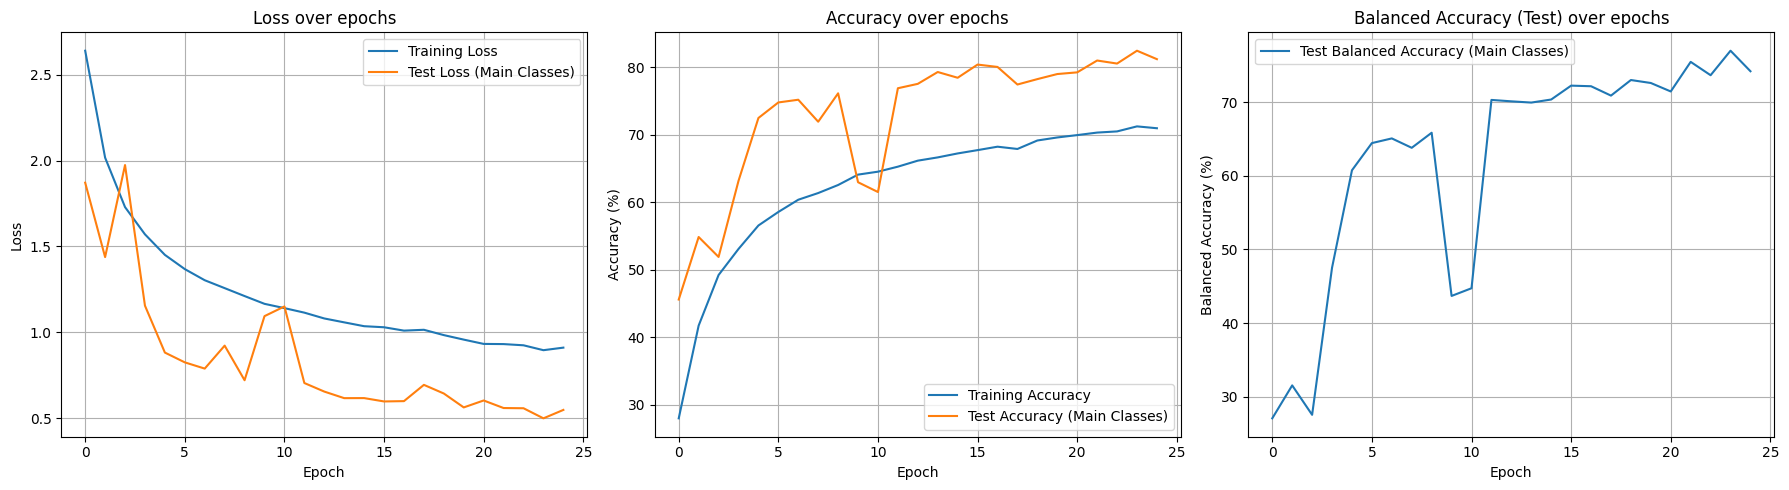

In [25]:

# 3. Create DataLoaders
# train_dataset and main_test_dataset should already be defined from your initial code
if 'train_dataset' not in locals() or 'main_test_dataset' not in locals():
    print("Please ensure train_dataset and main_test_dataset are defined.")
    # You might need to re-run the dataset creation part if in a new session/notebook section
else:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=cpu_count-1,
        pin_memory=True if device in ["cuda", "mps"] else False
    )

    test_loader = DataLoader(
        dataset=main_test_dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=cpu_count-1,
        pin_memory=True if device == ["cuda", "mps"] else False
    )

    print(f"Train loader: {len(train_loader)} batches, {len(train_loader.dataset)} samples")
    print(f"Test loader: {len(test_loader)} batches, {len(test_loader.dataset)} samples")


    # --- 4. Training Loop & 5. Evaluation Step ---
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    test_balanced_accuracies = []

    print("\nStarting training...")
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        epoch_start_time = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch

            # Calculate training accuracy for the batch
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % (len(train_loader) // 4) == 0 and i != 0 : # Print progress a few times per epoch
                 print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                       f"Batch Loss: {loss.item():.4f}")

        epoch_loss = running_loss / total_train
        epoch_acc = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Optional: Update learning rate scheduler
        # if 'scheduler' in locals():
        #     scheduler.step()

        # --- Evaluation on main_test_dataset after each epoch --- 
        model.eval()  # Set model to evaluation mode
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        all_test_preds = []
        all_test_labels = []

        with torch.no_grad(): # Disable gradient calculations for evaluation
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_test_preds.extend(predicted.cpu().numpy())
                all_test_labels.extend(labels.cpu().numpy())

        epoch_test_loss = running_test_loss / total_test
        epoch_test_acc = 100 * correct_test / total_test
        # Calculate Balanced Accuracy 
        epoch_test_balanced_acc = balanced_accuracy_score(all_test_labels, all_test_preds) * 100

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)
        test_balanced_accuracies.append(epoch_test_balanced_acc)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s:")
        print(f"  Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")
        print(f"  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.2f}%, Test Balanced Accuracy: {epoch_test_balanced_acc:.2f}%")
        # "A good model is expected to reach an accuracy and balanced accuracy of at least 75%."
        if epoch_test_acc >= 75 and epoch_test_balanced_acc >= 75:
            print(f"  Performance target reached on main classes test set at epoch {epoch+1}!")


    print("\nFinished Training.")

    # --- Plotting Training Progress ---
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss (Main Classes)")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy (Main Classes)")
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(test_balanced_accuracies, label="Test Balanced Accuracy (Main Classes)")
    plt.title("Balanced Accuracy (Test) over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Balanced Accuracy (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Save the trained model (Optional but recommended) ---
    # model_save_path = "fashion_resnet_cnn2_task1_final.pth"
    # torch.save(model.state_dict(), model_save_path)
    # print(f"Model saved to {model_save_path}")


## Task 2


In [26]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

## Task 3


In [27]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

## Task 4


In [28]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset